# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [69]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

from matplotlib import animation

In [70]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 30 # 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513016


## Level 0->1 Coarsening

### Relaxation

In [71]:
def animate_method_shrinkage(
    info, show: bool = True, save: bool = False, file_name: str = None,
    duration: float = 2):
    factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = info

    n = x_history[0].shape[0]
    # First set up the figure, the axis, and the plot element we want to animate
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    ax = axs[0]
    ax.clear()
    color = "blue"
    x_ticks = np.arange(1, len(conv) + 1)
    ax.set_xticks(x_ticks)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, len(conv)])
    line0 = ax.plot([], [], "o", color=color)[0]
    scatter0 = ax.scatter([], [], 120, facecolors='none', edgecolors=color)
    ax.set_ylabel("Residual Reduction Factor", fontsize=14)
    ax.set_xlabel("Sweep #", fontsize=14)
    #ax.grid(True)

    ax = axs[1]
    ax.clear()
    line1 = ax.plot([], [])[0]
    x_init = x_history[0][:, 0]
    ax.set_xlim([0, n - 1])
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Error", fontsize=14)

    ax = axs[2]
    ax.clear()
    line2 = ax.plot([], [])[0]
    r_init = r_history[0][:, 0]
    ax.set_xlim([0, n - 1])
    ax.set_ylim([min(r_init) - 0.01, max(r_init) + 0.01])
    ax.set_title("Residual", fontsize=14)

    # initialization function: plot the background of each frame
    def init():
        line0.set_data([], [])
        line1.set_data([], [])
        line2.set_data([], [])
        return line0, line1, line2

    # animation function.  This is called sequentially
    def animate(i):
        line0.set_data(x_ticks[:(i + 1)], conv[:(i + 1)])
        if i >= num_sweeps:
            scatter0.set_offsets(np.c_[[num_sweeps], [conv[num_sweeps - 1]]])
        line1.set_data(np.arange(n), x_history[i][:, 0])
        line2.set_data(np.arange(n), r_history[i][:, 0])
        axs[1].set_title("Error after {} sweeps".format(i), fontsize=14)
        axs[2].set_title("Residual after {} sweeps".format(i), fontsize=14)
        return line0, scatter0, line1, line2

    # call the animator.  blit=True means only re-draw the parts that have changed.
    num_frames = len(r_history)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=num_frames, interval=duration / num_frames, blit=True)
    fig.set_size_inches(18, 4)
    if save:
        anim.save(file_name, dpi=300, fps=num_frames / duration, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
    if show:
        video = anim.to_html5_video()
        html = display.HTML(video)
        display.display(html)
    plt.close()

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.363e+00                    4.470e-01    3.049
INFO     1     5.393e-01 (0.396) [0.396]    2.739e-01    1.977 (0.647)
INFO     2     2.250e-01 (0.418) [0.407]    2.075e-01    1.098 (0.554)
INFO     3     1.019e-01 (0.453) [0.422]    1.770e-01    0.592 (0.536)
INFO     4     5.285e-02 (0.518) [0.444]    1.592e-01    0.347 (0.581)
INFO     5     3.171e-02 (0.599) [0.472]    1.475e-01    0.229 (0.652)
INFO     6     2.152e-02 (0.677) [0.501]    1.389e-01    0.168 (0.724)
INFO     7     1.591e-02 (0.738) [0.530]    1.322e-01    0.132 (0.780)
INFO     8     1.245e-02 (0.782) [0.556]    1.268e-01    0.109 (0.819)
INFO     9     1.015e-02 (0.815) [0.580]    1.224e-01    0.092 (0.848)
INFO     10    8.505e-03 (0.839) [0.602]    1.185e-01    0.080 (0.869)
INFO     11    7.289e-03 (0.858) [0.622]    1.152e-01    0.070 (0.885)
INFO     12    6.357e-03 (0.873) [0.640]    1.123e-01    0.063 (0.898)
INFO 

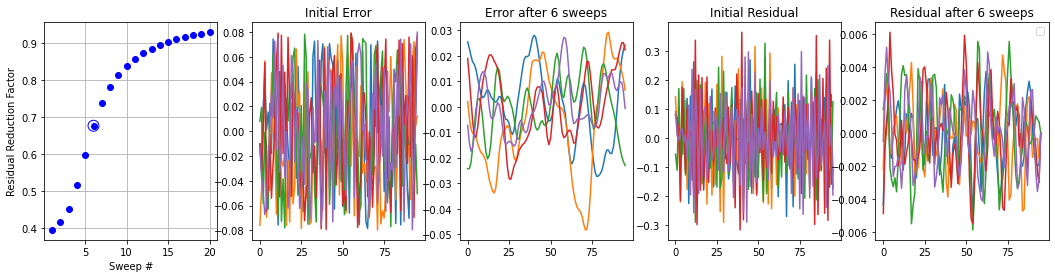

In [72]:
kh = 0

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []


method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["relax"][1]

# Generate animation video of Laplace/GS shrinkage.
info = method_info["relax"]
animate_method_shrinkage(method_info["relax"], show=False, save=True, file_name="laplace_shrinkage.mp4",
                        duration=4.0)

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.239e+00                    4.469e-01    2.775
INFO     1     4.155e-01 (0.336) [0.336]    3.068e-01    1.361 (0.490)
INFO     2     1.837e-01 (0.443) [0.386]    2.704e-01    0.684 (0.503)
INFO     3     1.149e-01 (0.625) [0.453]    2.542e-01    0.454 (0.665)
INFO     4     8.925e-02 (0.775) [0.519]    2.437e-01    0.368 (0.809)
INFO     5     7.628e-02 (0.853) [0.573]    2.355e-01    0.325 (0.882)
INFO     6     6.815e-02 (0.892) [0.617]    2.286e-01    0.298 (0.919)
INFO     7     6.238e-02 (0.915) [0.653]    2.226e-01    0.280 (0.940)
INFO     8     5.798e-02 (0.929) [0.682]    2.173e-01    0.267 (0.952)
INFO     9     5.443e-02 (0.939) [0.707]    2.124e-01    0.256 (0.961)
INFO     10    5.147e-02 (0.946) [0.728]    2.080e-01    0.248 (0.966)
INFO     11    4.892e-02 (0.951) [0.746]    2.038e-01    0.240 (0.970)
INFO     Relax conv 0.95 shrinkage 0.39 PODR RER 0.68 after 2 sweeps. Work 1

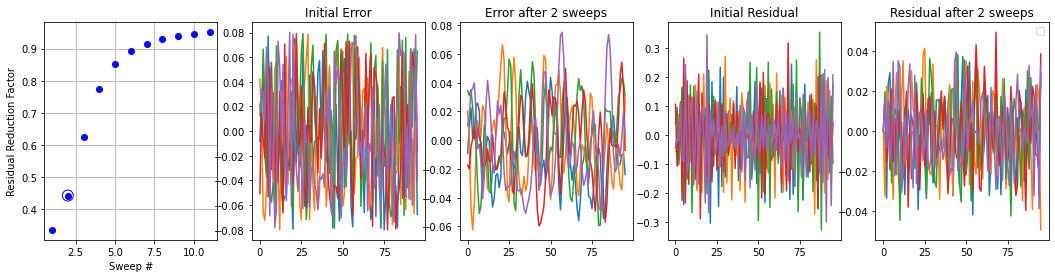

In [73]:
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
symmetrize = False # True

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(
    a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None, symmetrize=symmetrize)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["relax"][1]

# Generate animation video of Laplace/GS shrinkage.
info = method_info["relax"]
animate_method_shrinkage(method_info["relax"], show=False, save=True, file_name="kaczmarz_shrinkage.mp4",
                        duration=4.0)

In [31]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 30 sweeps
INFO     RER 0.155


### Coarsening: Fixed (4/2)

In [32]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

In [33]:
def animate_method_coarsening(
    level, num_sweeps: int, aggregate_size: int, num_components: int, file_name: str,
    duration: float = 2):

    # Create relaxed TVs.
    global x_tf
    colors = ("red", "green", "blue", "magenta")
    x_tf = hm.solve.run.random_test_matrix((level.a.shape[0],), num_examples=4)
    b = np.zeros_like(x_tf)
    x_ticks = np.arange(aggregate_size)

    # Set up initial figure.
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    ax = axs[0]
    # R should be real-valued, but cast just in case.
    r_lines = []
    for i in range(num_components):
        line = ax.plot([], [], color=colors[i])[0]
        r_lines.append(line)
    ax.set_xticks(x_ticks)
    ax.set_xlim([0, aggregate_size - 1])
    ax.set_ylim([-1, 1])
#    ax.set_title(r"$a = {}, n_c = {}$".format(aggregate_size, num_components), fontsize=14)
    ax.set_ylabel(r"Principal Components", fontsize=14)
    ax.grid(True)
    text = ax.text((aggregate_size - 1) / 2 - 0.1 * aggregate_size / 4, 1.05, "$\\nu = 0$", fontsize=12)

    # Singular values, normalized to sigma_max = 1.
    ax = axs[1]
    s_scatter = ax.scatter([], [], 120, facecolors='none', edgecolors="#994c00")
    ax.set_xticks(x_ticks)
    ax.set_xlim([-0.1, aggregate_size - 1 + 0.1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel(r"$i$")
    ax.set_ylabel(r"$\sigma_i$", fontsize=14)
    s_text = []
    for xi in x_ticks:
        si_text = ax.text(xi - 0.1 * aggregate_size / 3, 1.08, "$-$", fontsize=12)
        s_text.append(si_text)

    # initialization function: plot the background of each frame
    def init():
        for line in r_lines:
            line.set_data([], [])
        return r_lines + [s_scatter]

    # animation function.  This is called sequentially
    def animate(i):
        global x_tf
        x_tf = hm.solve.run.run_iterative_method(
           level.operator, lambda x: level.relax(x, b), x_tf, num_sweeps=1)[0]
        r, s = hm.repetitive.locality.create_coarsening(x_tf, aggregate_size, num_components, normalize=False)
        r = hm.linalg.normalize_signs(r.asarray(), axis=0)
        x_ticks = np.arange(aggregate_size)
        for j, line in enumerate(r_lines):
            line.set_data(x_ticks, r[j])
        sn = s / s[0]
        energy_error = (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5
        s_scatter.set_offsets(np.c_[x_ticks, sn])
        if i % 10 == 0:
            print("Frame {} s {}".format(i, sn))
            #print(r)
        text.set_text("$\\nu = {}$".format(i))
        for si_text, e in zip(s_text, energy_error):
            si_text.set_text("${:.3f}$".format(e))
        return r_lines + [s_scatter] + [text] + s_text

    # call the animator.  blit=True means only re-draw the parts that have changed.
    num_frames = num_sweeps
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=num_frames, interval=duration / num_frames, blit=True)
    fig.set_size_inches(12, 4)
    anim.save(file_name, dpi=300, fps=num_frames / duration, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])

INFO     Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO     MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3600x1200 -pix_fmt rgba -r 67.0 -loglevel error -i pipe: -vcodec h264 -vcodec libx264 -pix_fmt yuv420p -y r_4_2_vs_smoothing.mp4
Frame 0 s [1.    0.869 0.482 0.338]
Frame 10 s [1.    0.651 0.095 0.017]
Frame 20 s [1.    0.609 0.087 0.014]
Frame 30 s [1.    0.597 0.084 0.012]
Frame 40 s [1.    0.599 0.079 0.011]
Frame 50 s [1.    0.606 0.073 0.01 ]
Frame 60 s [1.    0.614 0.067 0.009]
Frame 70 s [1.    0.622 0.062 0.009]
Frame 80 s [1.    0.628 0.057 0.008]
Frame 90 s [1.    0.633 0.053 0.008]
Frame 100 s [1.    0.637 0.049 0.007]
Frame 110 s [1.    0.639 0.046 0.007]
Frame 120 s [1.    0.641 0.043 0.006]
Frame 130 s [1.    0.643 0.041 0.006]
Frame 140 s [1.    0.644 0.04  0.006]
Frame 150 s [1.    0.645 0.038 0.006]
Frame 160 s [1.    0.646 0.037 0.006]
Frame 170 s [1.    0.646 0.036 0.005]
Frame 180 s [1.    0.647 0.035 0.005]
Fra

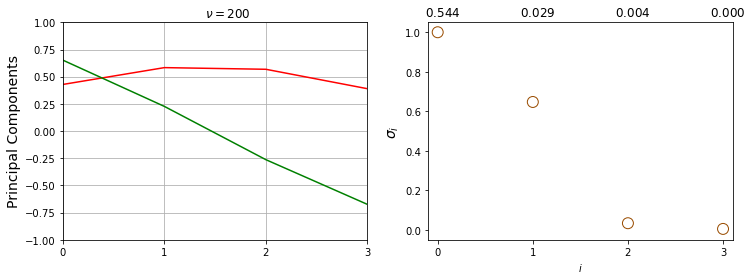

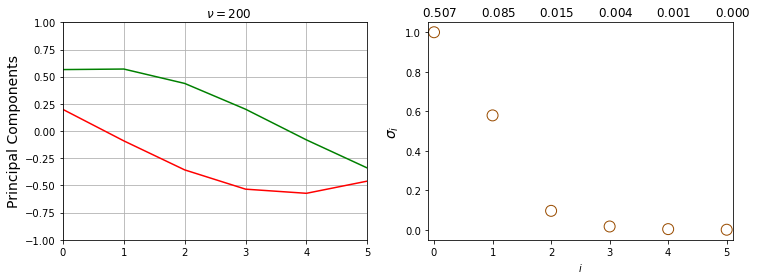

In [34]:
animate_method_coarsening(level, 201, 4, 2, "r_4_2_vs_smoothing.mp4", duration=3)
animate_method_coarsening(level, 201, 6, 2, "r_6_2_vs_smoothing.mp4", duration=3)

,0,1,2,3,4,5,6,7,8,9
0,-0.4295,-0.5703,-0.5638,-0.4152,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6562,0.2433,-0.2545,-0.6674,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.4295,-0.5703,-0.5638,-0.4152,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.6562,0.2433,-0.2545,-0.6674,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.4295,-0.5703


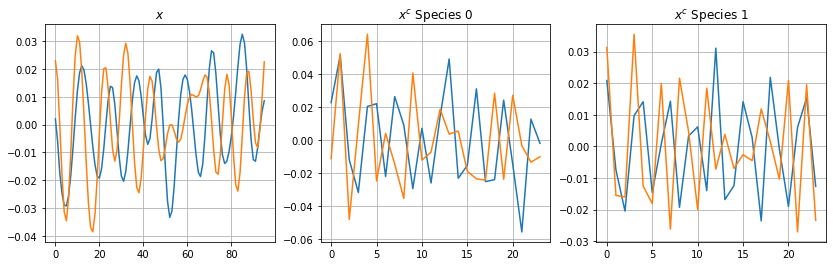

In [35]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

4 2


,0,1,2,3,4,5,6,7,8,9
0,-0.4295,-0.5703,-0.5638,-0.4152,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6562,0.2433,-0.2545,-0.6674,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.4295,-0.5703,-0.5638,-0.4152,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.6562,0.2433,-0.2545,-0.6674,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.4295,-0.5703


INFO     Mock cycle conv |domain|=24 [0.534 0.28  0.174 0.107 0.063 0.069 0.058 0.051]
INFO     Mock cycle eff |domain|=24 [0.73  0.727 0.747 0.756 0.759 0.8   0.816 0.831]
6 2


,0,1,2,3,4,5,6,7,8,9
0,-0.1359,-0.3536,-0.5081,-0.5470,-0.4652,-0.2876,0.0000,0.0000,0.0000,0.0000
1,0.5713,0.4730,0.2253,-0.0826,-0.3574,-0.5144,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.1359,-0.3536,-0.5081,-0.5470
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5713,0.4730,0.2253,-0.0826
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


INFO     Mock cycle conv |domain|=36 [0.818 0.721 0.62  0.453 0.456 0.393 0.336 0.25 ]
INFO     Mock cycle eff |domain|=36 [0.875 0.897 0.899 0.876 0.9   0.902 0.901 0.891]
6 3


,0,1,2,3,4,5,6,7,8,9
0,-0.1359,-0.3536,-0.5081,-0.5470,-0.4652,-0.2876,0.0000,0.0000,0.0000,0.0000
1,0.5713,0.4730,0.2253,-0.0826,-0.3574,-0.5144,0.0000,0.0000,0.0000,0.0000
2,-0.6190,-0.0790,0.2913,0.3164,-0.0469,-0.6507,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.1359,-0.3536,-0.5081,-0.5470
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5713,0.4730,0.2253,-0.0826


INFO     Mock cycle conv |domain|=36 [0.517 0.286 0.172 0.125 0.08  0.064 0.059 0.052]
INFO     Mock cycle eff |domain|=36 [0.719 0.731 0.745 0.771 0.777 0.795 0.817 0.831]


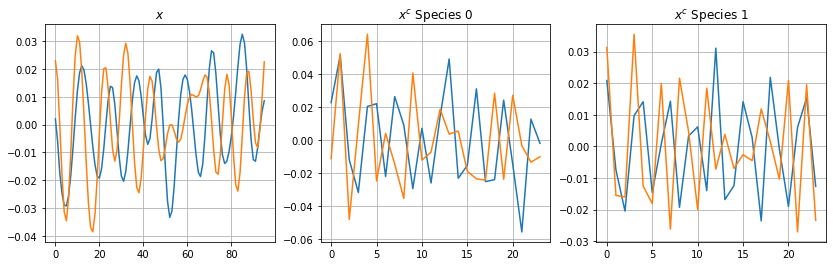

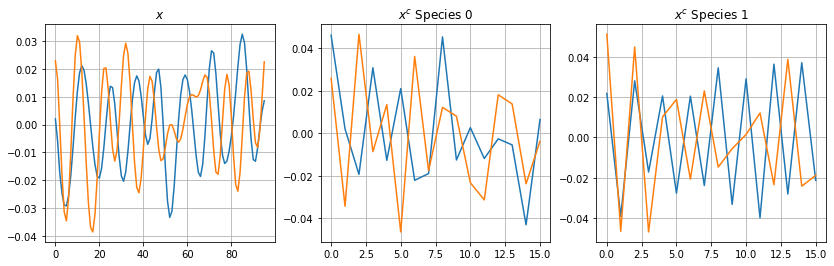

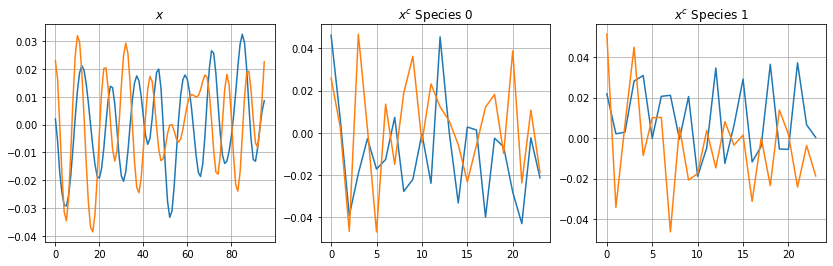

In [36]:
coarsening_types = [(4, 2), (6, 2), (6, 3)]
num_sweeps = 8
m = 6

for aggregate_size, num_components in coarsening_types:
    print(aggregate_size, num_components)
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    R = r.tile(level.size // aggregate_size)
    xc = R.dot(x)
    display(pd.DataFrame(R[:5,:10].todense()))
    hm.repetitive.locality.plot_coarsening(R, x)

    # Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
    nu_values = np.arange(1, num_sweeps + 1)
    work = nu_values / (1 - num_components / aggregate_size)
    mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
    _LOGGER.info("Mock cycle conv |domain|={} {}".format(
        m * aggregate_size, np.array2string(mock_conv, precision=3)))
    _LOGGER.info("Mock cycle eff |domain|={} {}".format(
        m * aggregate_size, np.array2string(mock_conv ** (1/work), precision=3)))


### Interpolation $P = R^T$

In [45]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

m0 = hm.repetitive.locality.create_two_level_hierarchy(
    kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size, num_components)
two_level_conv = np.array([hm.repetitive.locality.two_level_conv_factor(m0, nu)[1] for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()
display(conv)

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

,1,2,3,4,5,6,7,8
Mock,0.5172,0.2860,0.1716,0.1251,0.0799,0.0635,0.0587,0.0516
P=R^T,0.5916,0.4329,0.3456,0.2796,0.2290,0.1888,0.1536,0.1119


INFO     L2 projection norm 1.00 A*A' projection norm 3.13


#### Two-level Mini-Cycle Shrinkage

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.256e+00                    4.457e-01    2.807
INFO     1     4.041e-01 (0.322) [0.322]    2.958e-01    1.379 (0.488)
INFO     2     1.807e-01 (0.448) [0.381]    2.583e-01    0.711 (0.516)
INFO     3     1.134e-01 (0.626) [0.451]    2.413e-01    0.478 (0.673)
INFO     4     8.855e-02 (0.784) [0.518]    2.302e-01    0.393 (0.823)
INFO     5     7.587e-02 (0.866) [0.574]    2.216e-01    0.350 (0.900)
INFO     6     6.769e-02 (0.899) [0.618]    2.145e-01    0.322 (0.930)
INFO     7     6.179e-02 (0.917) [0.653]    2.083e-01    0.302 (0.945)
INFO     8     5.727e-02 (0.929) [0.683]    2.028e-01    0.287 (0.954)
INFO     9     5.367e-02 (0.937) [0.707]    1.978e-01    0.274 (0.961)
INFO     10    5.070e-02 (0.944) [0.728]    1.931e-01    0.265 (0.967)
INFO     11    4.820e-02 (0.949) [0.746]    1.888e-01    0.256 (0.971)
INFO     12    4.603e-02 (0.953) [0.761]    1.848e-01    0.250 (0.974)
INFO 

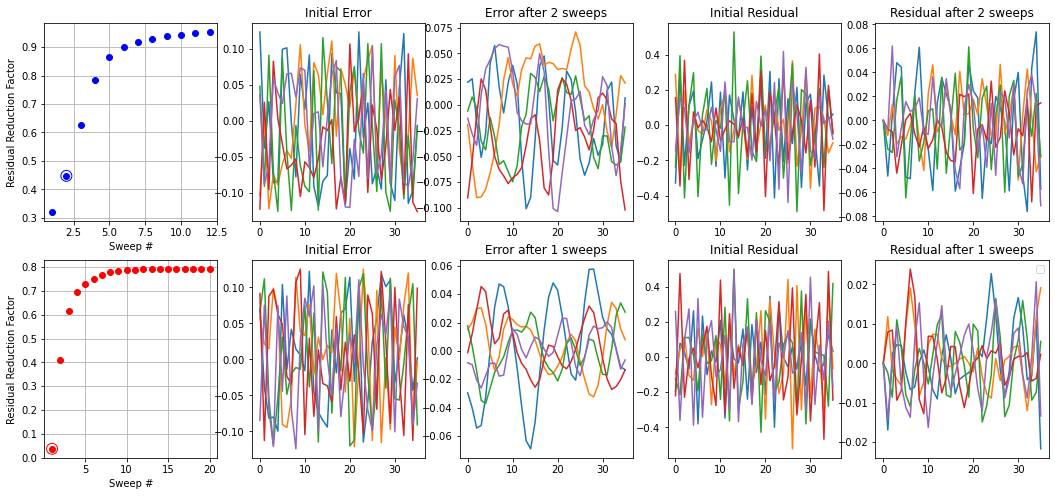

In [49]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m0, num_levels=2, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)

In [67]:
def animate_mini_cycle_shrinkage(
    method_info, show: bool = True, save: bool = False, file_name: str = None,
    duration: float = 2):
    factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = method_info["relax"]
    cycle_factor, cycle_num_sweeps, cycle_residual, cycle_conv, cycle_rer, \
        cycle_relax_conv_factor, cycle_x_history, cycle_r_history = method_info["2-level MiniCycle"]

    n = x_history[0].shape[0]
    x_ticks = np.arange(1, min(len(conv), len(cycle_conv)) + 1)
    num_frames = len(x_ticks)

    # First set up the figure, the axis, and the plot element we want to animate
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    ax = axs[0]
    ax.clear()
    ax.set_xticks(x_ticks)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, len(conv)])
    
    color = "blue"
    line0 = ax.plot([], [], "o", color=color)[0]
    scatter0 = ax.scatter([], [], 120, facecolors='none', edgecolors=color)

    color = "red"
    cycle_line0 = ax.plot([], [], "o", color=color)[0]
    cycle_scatter0 = ax.scatter([], [], 120, facecolors='none', edgecolors=color)
    
    ax.set_ylabel("Residual Reduction Factor", fontsize=14)
    ax.set_xlabel("Sweep #", fontsize=14)
    #ax.grid(True)

    ax = axs[1]
    ax.clear()
    error0 = ax.plot([], [])[0]
    x_init = x_history[0][:, 0]
    ax.set_xlim([0, n - 1])
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Relax Error", fontsize=14)

    ax = axs[2]
    ax.clear()
    cycle_error0 = ax.plot([], [])[0]
    x_init = cycle_x_history[0][:, 0]
    ax.set_xlim([0, n - 1])
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Mini-Cycle Error", fontsize=14)

    # initialization function: plot the background of each frame
    def init():
        line0.set_data([], [])
        cycle_line0.set_data([], [])
        error0.set_data([], [])
        cycle_error0.set_data([], [])
        return line0, cycle_line0, error0, cycle_error0

    # animation function.  This is called sequentially
    def animate(i):
        line0.set_data(x_ticks[:(i + 1)], conv[:(i + 1)])
        if i >= num_sweeps:
            scatter0.set_offsets(np.c_[[num_sweeps], [conv[num_sweeps - 1]]])
        cycle_line0.set_data(x_ticks[:(i + 1)], cycle_conv[:(i + 1)])
        if i >= num_sweeps:
            cycle_scatter0.set_offsets(np.c_[[cycle_num_sweeps], [cycle_conv[cycle_num_sweeps - 1]]])
            
        error0.set_data(np.arange(n), x_history[i][:, 0])
        cycle_error0.set_data(np.arange(n), cycle_x_history[i][:, 0])
        axs[1].set_title("Relax Error after {} sweeps".format(i), fontsize=14)
        axs[2].set_title("Mini-Cycle Error after {} sweeps".format(i), fontsize=14)
        return line0, cycle_line0, error0, cycle_error0, scatter0, cycle_scatter0

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=num_frames, interval=duration / num_frames, blit=True)
    fig.set_size_inches(18, 4)
    if save:
        anim.save(file_name, dpi=300, fps=num_frames / duration, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
    if show:
        video = anim.to_html5_video()
        html = display.HTML(video)
        display.display(html)
    plt.close()
    
animate_mini_cycle_shrinkage(method_info, show=False, save=True, file_name="mini_cycle_shrinkage.mp4",
                        duration=4.0)

INFO     Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO     MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 5400x1200 -pix_fmt rgba -r 3.0 -loglevel error -i pipe: -vcodec h264 -vcodec libx264 -pix_fmt yuv420p -y mini_cycle_shrinkage.mp4


### Interpolation by LS Fitting

In [13]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

/Users/olivne/opt/miniconda3/envs/hm/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


 ** On entry to DGEMV  parameter number  2 had an illegal value
 ** On entry to DTRSV  parameter number  6 had an illegal value
 ** On entry to DGEMV  parameter number  2 had an illegal value
 ** On entry to DTRSV  parameter number  6 had an illegal value
 ** On entry to DGEMV  parameter number  2 had an illegal value
 ** On entry to DTRSV  parameter number  6 had an illegal value
 ** On entry to DGEMV  parameter number  2 had an illegal value
 ** On entry to DTRSV  parameter number  6 had an illegal value
 ** On entry to DGEMV  parameter number  2 had an illegal value
 ** On entry to DTRSV  parameter number  6 had an illegal value
 ** On entry to DGEMV  parameter number  2 had an illegal value
 ** On entry to DTRSV  parameter number  6 had an illegal value
 ** On entry to DGEMV  parameter number  2 had an illegal value
 ** On entry to DGEMV  parameter number  2 had an illegal value
 ** On entry to DTRSV  parameter number  6 had an illegal value
 ** On entry to DGEMV  parameter number 

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,nan,nan,nan,nan,nan,0.52,0.29,0.17,0.13,0.08,0.06,0.06,0.05
P=R^T,nan,nan,nan,nan,nan,0.58,0.44,0.35,0.28,0.23,0.19,0.12,0.13
P^T A P caliber 2,0.00,2.00,192.00,0.80,0.00,nan,nan,nan,nan,nan,nan,nan,nan
P^T A P caliber 3,0.00,3.00,288.00,1.80,0.00,0.61,0.43,0.35,0.27,0.23,0.19,0.15,0.13
P^T A P caliber 4,0.00,4.00,384.00,1.93,0.00,0.61,0.43,0.32,0.28,0.22,0.18,0.16,0.13
R A P caliber 2,1.00,2.00,192.00,1.20,0.46,nan,nan,nan,nan,nan,nan,nan,nan
R A P caliber 3,1.00,3.00,288.00,1.80,0.02,0.60,0.42,0.34,0.26,0.23,0.19,0.15,0.13
R A P caliber 4,1.00,4.00,384.00,1.80,0.03,0.59,0.43,0.34,0.28,0.23,0.19,0.15,0.13


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [14]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} P".format(caliber))
        display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
        print("A^1")
        display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))
        #ac2 = ac.transpose().dot(ac)
        #display(pd.DataFrame(ac2.todense()[:14,:14]))

P^T*A*P
caliber 2 P


,0,1
0,-0.1017,0.5637
1,-0.3528,0.4663
2,-0.5052,0.2249
3,-0.5588,-0.0748
4,-0.4608,-0.3560
5,-0.2573,-0.5273


A^1


,0,1,2,3,4,5
0,0.0390,-0.1090,0.0234,-0.1617,0.0234,0.0530
1,-0.1090,-0.7187,0.0530,-0.3591,-0.1617,-0.3591
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


caliber 3 P


,0,1,2
0,-0.1332,0.5743,-0.6288
1,-0.3558,0.4673,-0.0611
2,-0.5088,0.2243,0.2969
3,-0.5452,-0.0809,0.3107
4,-0.4636,-0.3551,-0.0563
5,-0.2891,-0.5165,-0.6388


A^1


,0,1,2,3,4,5,6,7,8
0,0.0473,-0.1115,0.0285,0.0376,-0.1880,0.2166,0.0376,0.0725,0.0939
1,-0.1115,-0.7179,-0.0107,0.0725,-0.3584,0.4118,-0.1880,-0.3584,-0.4616
2,0.0285,-0.0107,-1.7953,0.0939,-0.4616,0.5293,0.2166,0.4118,0.5293


caliber 4 P


,0,1,2,3,4
0,-0.1466,0.5748,-0.5915,0.0000,-0.0207
1,-0.3425,0.4686,-0.1040,0.0000,0.0222
2,-0.5018,0.2239,0.2780,0.0000,0.0106
3,-0.5391,-0.0806,0.2955,0.0118,0.0000
4,-0.4521,-0.3545,-0.0849,0.0221,0.0000
5,-0.2991,-0.5170,-0.6142,-0.0191,0.0000


A^1


,0,1,2,3,4,5,6,7,8,9,10
0,0.0633,-0.1096,0.0240,0.0417,-0.1813,0.1792,0.0001,0.0001,0.0417,0.0684,0.0683
1,-0.1096,-0.7191,-0.0202,0.0684,-0.3591,0.3858,0.0000,0.0000,-0.1813,-0.3591,-0.4427
2,0.0240,-0.0202,-1.5803,0.0683,-0.4427,0.4749,0.0000,0.0000,0.1792,0.3858,0.4749


R*A*P
caliber 2 P


,0,1
0,-0.1017,0.5637
1,-0.3528,0.4663
2,-0.5052,0.2249
3,-0.5588,-0.0748
4,-0.4608,-0.3560
5,-0.2573,-0.5273


A^1


,0,1,2,3,4,5
0,0.0461,-0.1080,0.0266,-0.1832,0.0338,0.0760
1,-0.1103,-0.7144,0.0516,-0.3499,-0.1639,-0.3639
2,0.1102,-0.0555,0.0688,-0.4616,0.1869,0.4134


caliber 3 P


,0,1,2
0,-0.1332,0.5743,-0.6288
1,-0.3558,0.4673,-0.0611
2,-0.5088,0.2243,0.2969
3,-0.5452,-0.0809,0.3107
4,-0.4636,-0.3551,-0.0563
5,-0.2891,-0.5165,-0.6388


A^1


,0,1,2,3,4,5,6,7,8
0,0.0478,-0.1085,0.0271,0.0374,-0.1868,0.2153,0.0386,0.0744,0.0963
1,-0.1109,-0.7142,-0.0127,0.0721,-0.3568,0.4099,-0.1868,-0.3562,-0.4587
2,0.0262,-0.0262,-1.7960,0.0957,-0.4707,0.5398,0.2128,0.4046,0.5201


caliber 4 P


,0,1,2,3,4
0,-0.1466,0.5748,-0.5915,0.0000,-0.0207
1,-0.3425,0.4686,-0.1040,0.0000,0.0222
2,-0.5018,0.2239,0.2780,0.0000,0.0106
3,-0.5391,-0.0806,0.2955,0.0118,0.0000
4,-0.4521,-0.3545,-0.0849,0.0221,0.0000
5,-0.2991,-0.5170,-0.6142,-0.0191,0.0000


A^1


,0,1,2,3,4,5,6,7,8
0,0.0587,-0.1087,0.0268,0.0400,-0.1869,0.2014,0.0421,0.0745,0.0923
1,-0.1090,-0.7148,-0.0210,0.0683,-0.3570,0.3836,-0.1805,-0.3566,-0.4396
2,0.0199,-0.0268,-1.6833,0.0703,-0.4711,0.5052,0.1864,0.4050,0.4985


In [15]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_experiment[True][-1]  # R*A*P P high order
#p = p_experiment[True][0]  # R*A*P P=R^T

### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 1.976e+01 RER 3.52974
INFO         1 |r| 7.375e-01 (0.03732) RER 0.12456 (0.03529) 5.921
INFO         2 |r| 1.110e-01 (0.15056) RER 0.01847 (0.14825) 6.013
INFO         3 |r| 1.980e-02 (0.17832) RER 0.00329 (0.17799) 6.024
INFO         4 |r| 3.731e-03 (0.18842) RER 0.00062 (0.18837) 6.026
INFO         5 |r| 7.323e-04 (0.19630) RER 0.00012 (0.19630) 6.026
INFO         6 |r| 1.481e-04 (0.20229) RER 0.00002 (0.20228) 6.026
INFO         7 |r| 3.061e-05 (0.20664) RER 0.00001 (0.20664) 6.026
INFO         8 |r| 6.420e-06 (0.20973) RER 0.00000 (0.20973) 6.026
INFO         9 |r| 1.361e-06 (0.21191) RER 0.00000 (0.21191) 6.026
INFO        10 |r| 2.904e-07 (0.21344) RER 0.00000 (0.21344) 6.026
INFO        11 |r| 6.229e-08 (0.21452) RER 0.00000 (0.21452) 6.026
INFO        12 |r| 1.341e-08 (0.21531) RER 0.00000 (0.21531) 6.026
INFO        13 |r| 2.896e-09 (0.21590) RER 0.00000 (0.21590) 6.026
INFO        14 |r| 6.265e-10 (0.21635) RER 0.00000 (0.21635) 6.026
INFO        15 |r| 1.

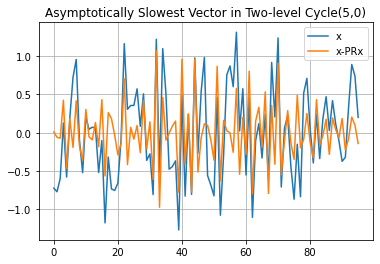

In [16]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 5
use_r_as_restriction = True

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - m0[1].interpolate(m0[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [17]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [ 0.    -0.001  0.064  0.064 -0.073 -0.073  0.119  0.119 -0.154 -0.154  0.166  0.166]


In [18]:
m0[1].a

<48x48 sparse matrix of type '<class 'numpy.float64'>'
	with 432 stored elements in Compressed Sparse Row format>

In [19]:
pd.set_option("display.precision", 3)
pd.DataFrame(m0[1].a.todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0587,-0.1087,0.0268,0.0400,-0.1869,0.2014,0.0000,0.0000,0.0000,0.0000
1,-0.1090,-0.7148,-0.0210,0.0683,-0.3570,0.3836,0.0000,0.0000,0.0000,0.0000
2,0.0199,-0.0268,-1.6833,0.0703,-0.4711,0.5052,0.0000,0.0000,0.0000,0.0000
3,0.0421,0.0745,0.0923,0.0587,-0.1087,0.0268,0.0400,-0.1869,0.2014,0.0000
4,-0.1805,-0.3566,-0.4396,-0.1090,-0.7148,-0.0210,0.0683,-0.3570,0.3836,0.0000
5,0.1864,0.4050,0.4985,0.0199,-0.0268,-1.6833,0.0703,-0.4711,0.5052,0.0000
6,0.0000,0.0000,0.0000,0.0421,0.0745,0.0923,0.0587,-0.1087,0.0268,0.0400
7,0.0000,0.0000,0.0000,-0.1805,-0.3566,-0.4396,-0.1090,-0.7148,-0.0210,0.0683
8,0.0000,0.0000,0.0000,0.1864,0.4050,0.4985,0.0199,-0.0268,-1.6833,0.0703
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0421,0.0745,0.0923,0.0587


In [20]:
pd.DataFrame((m0[1].a - m0[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,0.0004,0.0070,-0.0021,-0.0065,0.0150,0.0000,0.0000,0.0000,0.0000
1,-0.0004,0.0000,0.0058,-0.0061,-0.0005,-0.0214,0.0000,0.0000,0.0000,0.0000
2,-0.0070,-0.0058,0.0000,-0.0220,-0.0314,0.0067,0.0000,0.0000,0.0000,0.0000
3,0.0021,0.0061,0.0220,0.0000,0.0004,0.0070,-0.0021,-0.0065,0.0150,0.0000
4,0.0065,0.0005,0.0314,-0.0004,0.0000,0.0058,-0.0061,-0.0005,-0.0214,0.0000
5,-0.0150,0.0214,-0.0067,-0.0070,-0.0058,0.0000,-0.0220,-0.0314,0.0067,0.0000
6,0.0000,0.0000,0.0000,0.0021,0.0061,0.0220,0.0000,0.0004,0.0070,-0.0021
7,0.0000,0.0000,0.0000,0.0065,0.0005,0.0314,-0.0004,0.0000,0.0058,-0.0061
8,0.0000,0.0000,0.0000,-0.0150,0.0214,-0.0067,-0.0070,-0.0058,0.0000,-0.0220
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0021,0.0061,0.0220,0.0000


<!-- #### $P^T A Q$ Coarsening
This is not exactly a matrix multiplication $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil. -->

## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [21]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

num_sweeps_on_vectors = 100

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [22]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     5.785e-01                    4.446e-01    1.303
INFO     1     1.610e-01 (0.278) [0.278]    2.846e-01    0.565 (0.434)
INFO     2     1.184e-01 (0.737) [0.453]    2.570e-01    0.461 (0.815)
INFO     3     9.986e-02 (0.844) [0.557]    2.389e-01    0.418 (0.908)
INFO     4     8.801e-02 (0.881) [0.625]    2.247e-01    0.391 (0.937)
INFO     5     7.903e-02 (0.898) [0.672]    2.130e-01    0.371 (0.947)
INFO     6     7.171e-02 (0.907) [0.707]    2.029e-01    0.353 (0.952)
INFO     7     6.555e-02 (0.914) [0.733]    1.943e-01    0.337 (0.955)
INFO     8     6.026e-02 (0.920) [0.754]    1.867e-01    0.322 (0.957)
INFO     9     5.566e-02 (0.924) [0.772]    1.800e-01    0.309 (0.958)
INFO     10    5.162e-02 (0.928) [0.786]    1.741e-01    0.296 (0.959)
INFO     11    4.804e-02 (0.931) [0.798]    1.688e-01    0.285 (0.960)
INFO     12    4.486e-02 (0.934) [0.809]    1.641e-01    0.273 (0.961)
INFO 

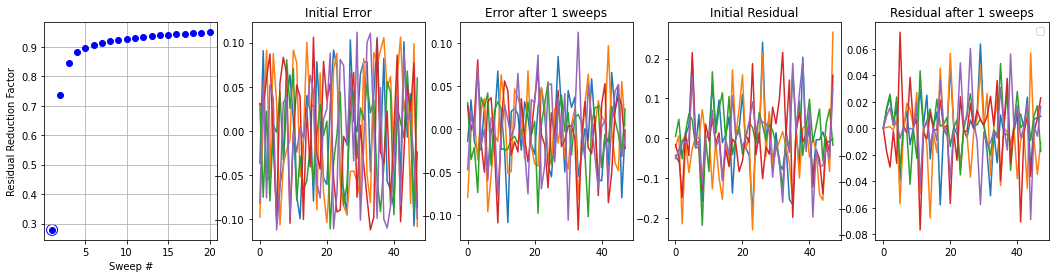

In [23]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["relax"][1]

In [24]:

# #PCs revealed by relaxed vectors of increasing smoothness.
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

NameError: name 'plot_svd_coarsening_accuracy' is not defined

In [ ]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

In [ ]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

In [ ]:
#plt.plot(x[:, 0][1::2])
#plt.plot(x[:, 1][1::2])
#plt.plot(x[:, 2][1::2])

#plt.plot(x[:, 1])

In [ ]:
# def autocorr(x):
#     result = np.correlate(x, x, mode='full')
#     return result[result.size//2:]

In [ ]:
 # np.correlate(x[:, 0], x[:, 0], mode='full')

In [ ]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Mock Cycle Rate

In [ ]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, 12)
mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
#hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

In [ ]:
# hm.setup.geometry.geometric_neighbors_from_locations(location[0], location[1], n, aggregate_size)[:, :4]
# num_aggregates = int(np.ceil(multilevel[0].a.shape[0] / aggregate_size))
# num_coarse_vars = nc * num_aggregates
# np.mod(hm.setup.geometry.geometric_neighbors(aggregate_size, num_components), num_coarse_vars)

### Interpolation $P = R^T$

In [ ]:
#### Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
            level.a, level.location, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(level.size // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(level.a)).todense(), ord=2)))

### Interpolation by LS Fitting

In [ ]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        #print(a.shape, R.shape, level.location.shape)
        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                level.a, level.location, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

### Solving $Ax = b$ - Convergence History

In [ ]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 2
p = p_experiment[True][-1]  # P^T*A*P P high order
use_r_as_restriction = True

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [ ]:
m1[1].a

In [ ]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

## 3-Level Method

In [ ]:
m0.add(m1[1])

In [ ]:
nu_pre = 4
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu_pre, nu_post=nu_post, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Cycle({}, 0)".format(nu_pre, nu_post))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [ ]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

In [ ]:
# Save A^1 to file.
#scipy.sparse.save_npz('level_1_operator.npz', m0[1].a)

In [ ]:
pd.DataFrame(m1[1].a.todense()[:10, :10])

In [ ]:
pd.DataFrame((m1[1].a - m1[1].a.transpose()).todense()[:10, :10])